# Kaggle NLP series - 2nd Task - Tweet Sentiment Extraction

### Hi Everyone, This is the second notebook in my NLP Kaggle series. In previous notebook we saw a simple toxic comment classification (https://www.kaggle.com/sasidharturaga/eda-step-wise-preprocess-and-lstm-classifier). 
### In this one lets find out the "word or phrase" from the tweet that exemplifies the provided sentiment

# Do upvote if you find this helpful. Let's get started.

### I am going to perform EDA and discuss different methods of tackling the problem

## Brief description about the problem

* A set of sentences and their sentiment labels (postive, negative and neutral) are given.
* The task for us is to identify and extract the part of sentences which are mainly responsible for the sentiment associated with sentence.

### Sentiment classification vs Sentiment Extraction

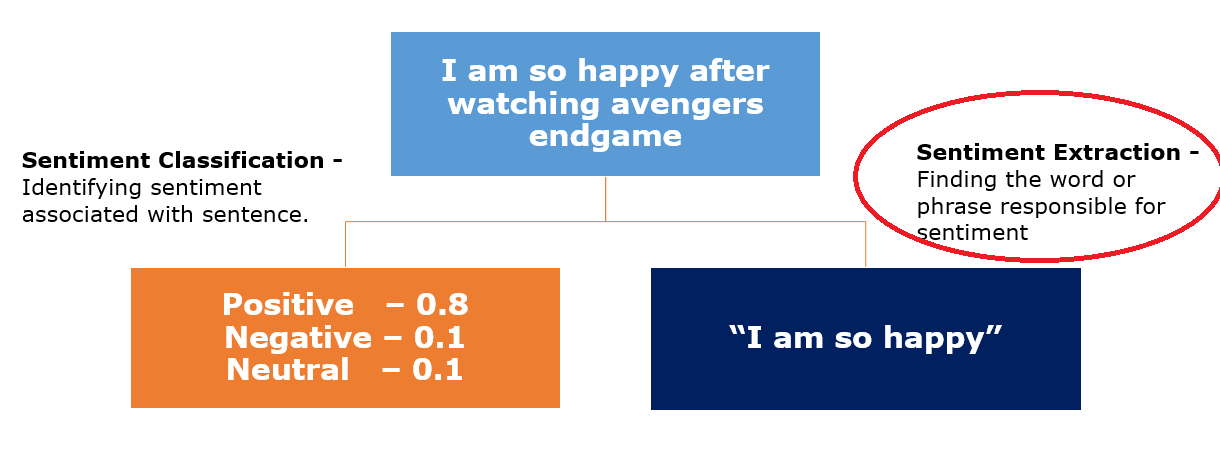

### In our task sentiment labels are given and we have to extract phrases responsible for that sentiment. So, Let's get started

## **Import basic libraries and let's have a look at the data**

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
train=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
test=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
samp_sub=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/sample_submission.csv")
print(train.shape,test.shape)

In [ ]:
train.head(3)

In [ ]:
#checking if there are any empty rows
print(train.isnull().sum()),print(test.isnull().sum())

In [ ]:
#one missing value in train lets see what it is and remove it
print(train[train.text.isna()])

train.dropna(axis=0,inplace=True)

print(train.shape)

## Here we have text and sentiment column and we have to predict selected_text column. Now let's do some EDA regarding sentiment distribution and sentence lengths

In [ ]:
import plotly.express as px

df1=pd.DataFrame(train["sentiment"].value_counts()).reset_index()
df1["Label"]=df1["index"]
df1["Count of Sentences"]=df1["sentiment"]
df1=df1.sort_values("sentiment", ascending=False)
fig = px.bar(df1, x="Label", y="Count of Sentences", title="No. of sentences per label",color="Count of Sentences",text="Count of Sentences")
fig.update_traces( textposition='outside')
fig.show()

In [ ]:
#now lets look at sentence lengths

train['text_lengths'] = train.apply(lambda row: len(row['text'].split(" ")), axis=1)
px.histogram(train['text_lengths'])

### Good, most of the sentences are falling within range 1-40. We cannot remove characters or any non-alphanumeric values from sentence beacuse in the challenge it is clearly mentioned that word or phrase should include all characters within that span (i.e. including commas, spaces, etc.)

### Jaccard score is the evaluating metric for the task. Let's look at an example which explains how jaccard similarity works
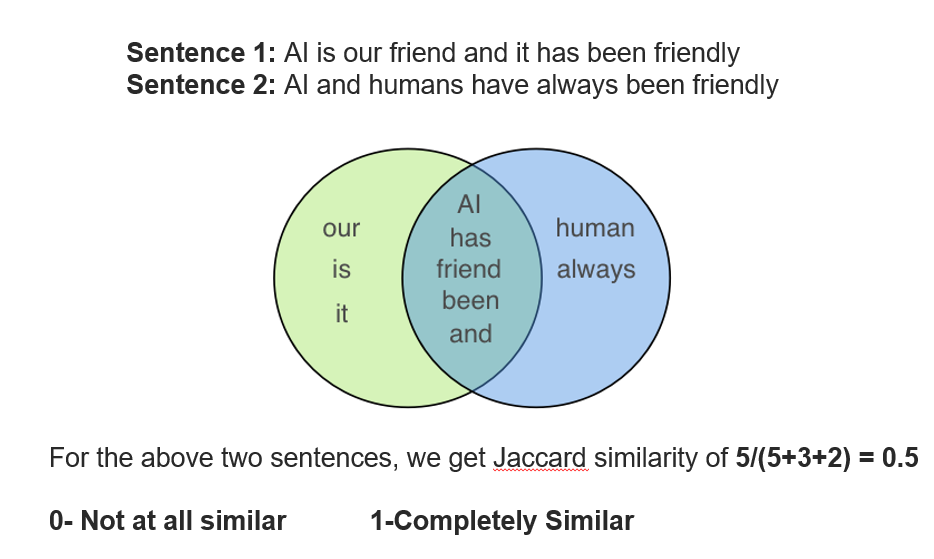

## Now let's look at how jaccard distribution looks like for each sentiment

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

train["jaccard_score"]= [jaccard(train.at[i,"selected_text"],train.at[i,"text"]) for i in train.index]

## Jaccard distribution for neutral sentiment sentences

In [ ]:

df1=train[train["sentiment"]=="neutral"]
px.histogram(df1, x="jaccard_score", color="sentiment")

## From above graphs its is evident that most of the "selected texts" having "neutral" sentiment are the "entire sentences" thats why most of the distribution of jaccard score is near 1.

## Jaccard distribution for positive sentiment sentences

In [ ]:
#jaccard distribution for positive
df1=train[train["sentiment"]=="positive"]
px.histogram(df1, x="jaccard_score", color="sentiment")

## Jaccard distribution for neutral sentiment sentences

In [ ]:
#jaccard distribution for negative
df1=train[train["sentiment"]=="negative"]
px.histogram(df1, x="jaccard_score", color="sentiment")

## Unlike neutral, "Positive" and "Negative" sentiments have somewat identical distribution of jaccard scores. 



# Now lets discuss in how many ways this problem can be solved

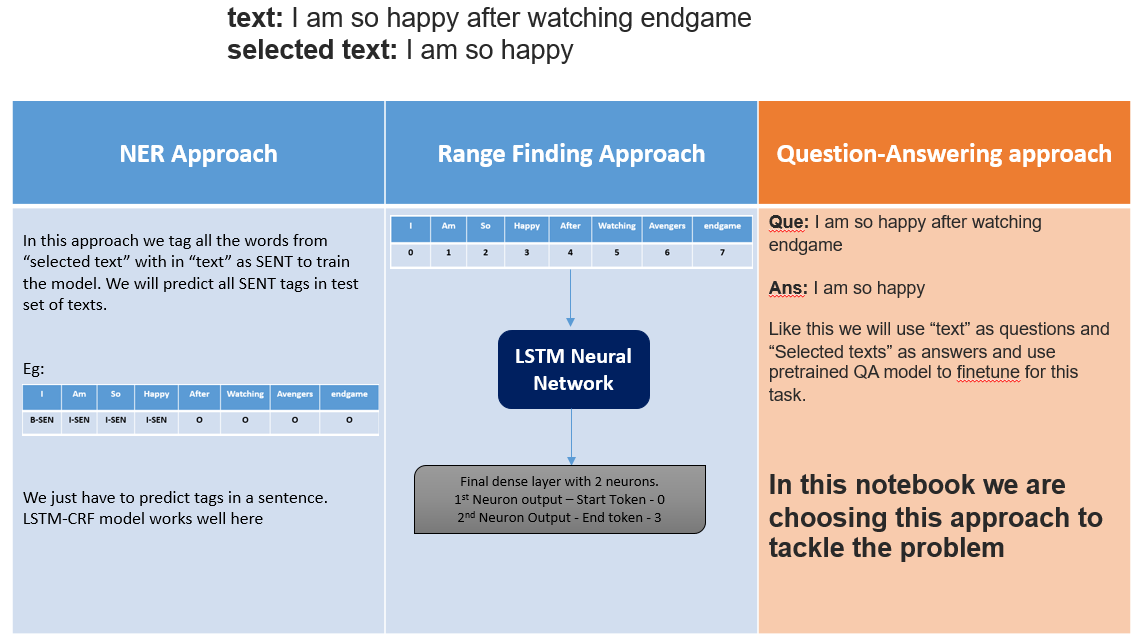

## Data prepration

### Download pretrained RoBERTa tokenizer

In [ ]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base',add_prefix_space=True)

In [ ]:
# converting everythin to lower case
train['text'] = train['text'].apply(lambda x : str(x).lower())
train['selected_text'] = train['selected_text'].apply(lambda x : str(x).lower())

In [ ]:
train

## Steps:
### 1) Split the data in to train and validation

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val , y_train , y_val = train_test_split(train[['text','sentiment']],train['selected_text'],test_size=0.2, random_state=42)
x_train.shape, x_val.shape , y_train.shape , y_val.shape

### 2) Tokenize data - convert string to list of numbers with pretrained tokenizer 
### 3) Prepare Attention mask - helps model in paying attention to actual tokens of sentences rather than padded tokens

## In below two cells steps 2 and 3 are performed on train and validation data

In [ ]:
max_length=128
count = x_train.shape[0]
input_ids = np.zeros((count,max_length),dtype='int32')
attention_mask = np.zeros((count,max_length),dtype='int32')
start_tokens = np.zeros((count,max_length),dtype='int32')
end_tokens = np.zeros((count,max_length),dtype='int32')
toks_all = []
from tqdm import tqdm

for i,sent in tqdm(enumerate(x_train.values)):
    
    #appending sentiment as a word and converting it into a tokenizer
    nums = tokenizer.encode_plus(sent[0],sent[1],add_special_tokens=True,max_length=128,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
    input_ids[i]=nums["input_ids"]
    attention_mask[i] = nums['attention_mask']
    
    text1 = " "+" ".join(sent[0].split())
    text2 = " ".join(y_train.values[i].split())
    
    
    #finding the start index of selected text
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1 #fillining ones where the selected text is in original text
    if text1[idx-1]==' ':
        chars[idx-1] = 1


    enc = tokenizer.encode(text1) 
    offsets = []
    idx=0
    for t in enc:
        w=tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)

    toks = []
    for c,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0:
            toks.append(c)
    toks_all.append(toks)    
    if len(toks)>0:
        count+=1
        start_tokens[i,(toks[0])+1] = 1
        end_tokens[i,(toks[-1])+1] = 1

In [ ]:
max_length=128
count = y_val.shape[0]
input_ids_val = np.zeros((count,max_length),dtype='int32')
attention_mask_val = np.zeros((count,max_length),dtype='int32')
start_tokens_val = np.zeros((count,max_length),dtype='int32')
end_tokens_val = np.zeros((count,max_length),dtype='int32')
toks_all = []


count=0
for i,each in tqdm(enumerate(x_val.values)):
    val = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=128,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
    input_ids_val[i] = val['input_ids']
    attention_mask_val[i] = val['attention_mask']
    
    
    text1 = " "+" ".join(each[0].split())
    text2 = " ".join(y_val.values[i].split())
    
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ':
        chars[idx-1] = 1


    enc = tokenizer.encode(text1) 
    offsets = []; idx=0
    for t in enc:
        w=tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)

    toks = []
    for c,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0:
            toks.append(c)
    toks_all.append(toks)    
    if len(toks)>0:
        count+=1
        start_tokens_val[i,(toks[0])+1] = 1
        end_tokens_val[i,(toks[-1])+1] = 1

In [ ]:
print(input_ids.shape,attention_mask.shape,start_tokens.shape,end_tokens.shape)
print(input_ids_val.shape,attention_mask_val.shape,start_tokens_val.shape,end_tokens_val.shape)

# Download pretrained RoBERTa QA model

In [ ]:
from transformers import TFRobertaForQuestionAnswering
roberta = TFRobertaForQuestionAnswering.from_pretrained('roberta-base')

# Design model with tensorflow

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Softmax,Dense,Activation,Dropout
import tensorflow as tf

input1 = Input(shape=(max_length,),name='input_id',dtype=tf.int32)
input2 = Input(shape=(max_length,),name='attention_mask',dtype=tf.int32)
start_scores,end_scores = roberta(input1,attention_mask = input2)
dense1 = Dense(units=max_length,activation='relu',name='dense1',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(start_scores)
drop1 = Dropout(0.4)(dense1)
dense11 = Dense(units=max_length,activation='relu',name='dense11',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(drop1)
softmax1 = Activation('softmax')(dense11)
dense2 = Dense(units=max_length,activation='relu',name='dense2',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(end_scores)
drop2 = Dropout(0.4)(dense2)
dense22 = Dense(units=max_length,activation='relu',name='dense22',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(drop2)
softmax2 = Activation('softmax')(dense22)

model = Model(inputs=[input1,input2],outputs=[softmax1,softmax2])
model.summary()

# A detailed picture of model and its flow

In [ ]:
tf.keras.utils.plot_model(model, 'Model.png',show_shapes=True)

In [ ]:
input_data = (input_ids,attention_mask)
output_data = (start_tokens,end_tokens)

val = (input_ids_val,attention_mask_val)
output_val = (start_tokens_val,end_tokens_val)
val_data = (val,output_val)

## Model parameters and compiling

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
model.compile(optimizer=opt,loss='categorical_crossentropy')

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_data, output_data)).shuffle(buffer_size=1024).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(32)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="model2.hdf5",
    save_weights_only=True,
    monitor='val_loss',
    mode="min",
    save_best_only=True)

# Model training and validation

In [ ]:
model.fit(train_dataset,epochs=5,validation_data=val_dataset,callbacks=model_checkpoint_callback)

## I ran model only for 5 epochs. As you can see as epochs progress train and validation loss are getting REDUCED. Hyper parameter tuning and more epochs would bring more efficient model. Now lets see the predictions

# Test data preparation

In [ ]:
test['text'] = test['text'].apply(lambda x : str(x).lower())

In [ ]:
max_length=128
test1=test[["text","sentiment"]]
count = test1.shape[0]
input_ids_tes = np.zeros((count,max_length),dtype='int32')
attention_mask_tes = np.zeros((count,max_length),dtype='int32')

for i,each in tqdm(enumerate(test1.values)):
    tes = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=128,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
    input_ids_tes[i] = tes['input_ids']
    attention_mask_tes[i] = tes['attention_mask']

# Model prediction

In [ ]:
test_data=(input_ids_tes,attention_mask_tes)
start_pred , end_pred= model.predict((test_data))
start_pred.shape,end_pred.shape

In [ ]:
strt_tes =[]
end_tes=[]
for i in tqdm(range(start_pred.shape[0])):
    s = tf.math.argmax(start_pred[i],axis=0).numpy()
    e = tf.math.argmax(end_pred[i],axis=0).numpy()
    strt_tes.append(s)
    end_tes.append(e)
print(len(strt_tes),len(end_tes)) 

pred_values = []
for i in tqdm(range(len(strt_tes))):
    index1 = strt_tes[i]
    index2 = end_tes[i] +2
    pred = input_ids_tes[i][index1:index2]
    mystring = tokenizer.decode(pred)
    pred_values.append(mystring)

In [ ]:
pred_values1=[i.split("</s>")[0] for i in pred_values] 

In [ ]:
pred_values1[0:5]

In [ ]:
samp_sub["selected_text"]=pred_values1

## Submission

In [ ]:
samp_sub.to_csv("sub1.csv",index=False)

## So in conclusion, we observerd a detailed EDA and different ways of tackling this problem and finally a very clear way of finetuning pretrained roberta model. That's it for 2nd task guys. See you again in Task 3.